# Effect of angular resolution on refractive layer transmission

In [1]:
import funcs

import numpy as np
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

deg = np.pi/180. # conversion factor degrees to radians
arcsec = 1/3600.*deg # conversion factor arcseconds to radians

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
nkDir     = workDir+'nk/'
datapath  = 'data/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'

In [3]:
# initialize wavelength scale and refractive indeces
wav = {'1A':np.linspace(4.83,5.,1000),'1B':np.linspace(5.6,6.7,1000)}
n_ZnS,n_Si,n_BE,n_SiAs,n_Al = [{} for i in range(5)]
for band in wav.keys():
    n_ZnS[band]  = funcs.indexOfRefractionZnS(wav[band])
    n_Si[band]   = funcs.indexOfRefractionSi(wav[band])
    n_BE[band]   = funcs.indexOfRefractionBE(wav[band])
    n_SiAs[band] = funcs.indexOfRefractionSiAs(wav[band])
    n_Al[band] = funcs.indexOfRefractionAl(wav[band])

In [4]:
d_list = [np.inf, 0.72e3,460.5e3,0.3e3,35e3, np.inf] # thickness, nanometers

Refl_0,Transm_0,Absorp_0 = {},{},{}
for band in ['1A']:
    Refl_0[band],Transm_0[band],Absorp_0[band] = [np.zeros(len(wav[band])) for i in range(3)]
    for i,wvl in enumerate(wav[band]):
        # define stack of refractive layers
        n_list = [1,n_ZnS[band][i],n_Si[band][i],n_BE[band][i],n_SiAs[band][i], n_Al[band][i]] # refractive index
        lambda_vac = wvl*1000. # convert microns to nanometers
        Refl_0[band][i],Transm_0[band][i],Absorp_0[band][i] = funcs.simple_tmm(n_list, d_list, 0.*deg, lambda_vac)

In [ ]:
# Simple averaging over 1 dimension
thetas = np.arange(0,9.01,0.01)

Refl,Transm,Absorp = {},{},{}
for band in ['1A']:
    Refl[band],Transm[band],Absorp[band] = [np.zeros(len(wav[band])) for i in range(3)]
    for i,wvl in enumerate(wav[band]):
        # define stack of refractive layers
        n_list = [1,n_ZnS[band][i],n_Si[band][i],n_BE[band][i],n_SiAs[band][i], n_Al[band][i]] # refractive index
        lambda_vac = wvl*1000. # convert microns to nanometers
        Refl[band][i],Transm[band][i],Absorp[band][i] = 0,0,0
        for theta in thetas:
            # solve the Fresnel equations using the Transfer-Matrix Method
            Reflectance,Transmittance,Absorptance = funcs.simple_tmm(n_list, d_list, theta*deg, lambda_vac)
            Refl[band][i] += Reflectance
            Transm[band][i] += Transmittance
            Absorp[band][i] += Absorptance
        Refl[band][i] /= len(thetas)
        Transm[band][i] /= len(thetas)
        Absorp[band][i] /= len(thetas)

In [11]:
# Simple averaging over 2 dimensions - nominal beam
n = 1000

length = 43.5*np.sqrt(np.random.uniform(0, 1, n))
angle = np.pi * np.random.uniform(0, 2, n)

thetas = np.arctan(length/297.)*180./np.pi

# # circle with coordinates
# x = length * np.cos(angle)
# y = length * np.sin(angle)

Refl,Transm,Absorp = {},{},{}
for band in ['1A']:
    Refl[band],Transm[band],Absorp[band] = [np.zeros(len(wav[band])) for i in range(3)]
    for i,wvl in enumerate(wav[band]):
        # define stack of refractive layers
        n_list = [1,n_ZnS[band][i],n_Si[band][i],n_BE[band][i],n_SiAs[band][i], n_Al[band][i]] # refractive index
        lambda_vac = wvl*1000. # convert microns to nanometers
        Refl[band][i],Transm[band][i],Absorp[band][i] = 0,0,0
        for theta in thetas:
            # solve the Fresnel equations using the Transfer-Matrix Method
            Reflectance,Transmittance,Absorptance = funcs.simple_tmm(n_list, d_list, theta*deg, lambda_vac)
            Refl[band][i] += Reflectance
            Transm[band][i] += Transmittance
            Absorp[band][i] += Absorptance
        Refl[band][i] /= len(thetas)
        Transm[band][i] /= len(thetas)
        Absorp[band][i] /= len(thetas)

In [75]:
print np.arctan(7./297.)
print np.arctan(43.5/297.)
print np.arctan(7./297.) *180./np.pi
print np.arctan(43.5/297.) *180./np.pi

0.0235646608344
0.145430608802
1.35015561147
8.33256009637


In [76]:
9.3*np.pi/180.

0.16231562043547265

In [15]:
n = 1
alpha = 0.0125
m = 496.875
lambda0 = 3180
F_a = 2*np.pi*n / (m*np.pi*alpha**2.)

print F_a
print "Collimation angle alpha = {} rad / {} deg".format(alpha,round(alpha*180./np.pi,3) )

25.7610062893
Collimation angle alpha = 0.0125 rad / 0.716 deg


<IPython.core.display.Javascript object>


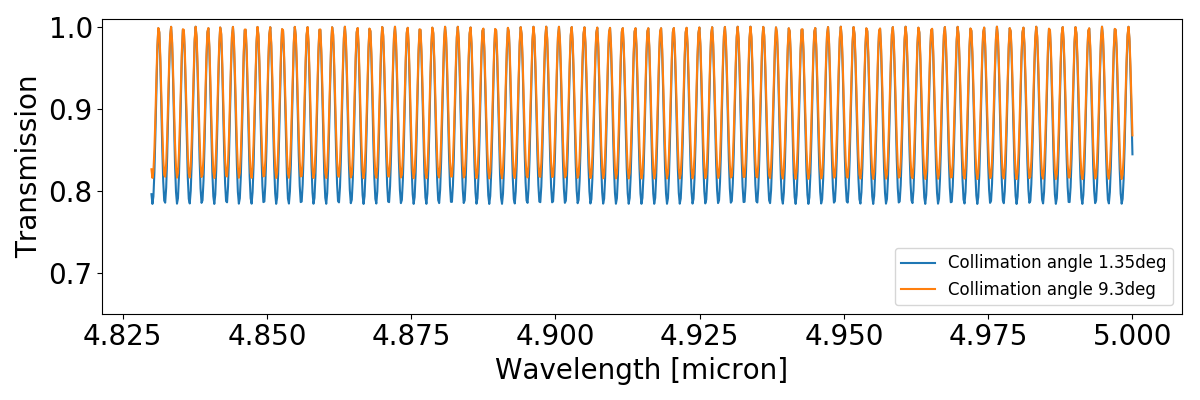

In [7]:
def FPfunc(wav,D,R,alpha,theta=0):
    lamb0 = 3180. # micron
    D_fp = 0.015 # m, diameter of the beam entering the etalon
    D_tel = 6.5 # m, diameter of primary mirror
    m = lamb0/wav
    n = funcs.indexOfRefractionSi(wav).real
    delta = (2*np.pi/wav)*2.*n*D*np.cos(theta*np.pi/180.)
    F = 4.*R/(1-R**2.)
    F_R = np.pi/(2*np.arcsin(1/np.sqrt(F)))
    F_R = np.pi*np.sqrt(R)/(1-R)
    F_a = 2*np.pi*n / (m*np.pi*alpha**2.)
    F_dif = D_fp**2 / (wav*10**-6 * D_tel)
    F_d = 42.2381 # surface defects
    F_e = np.sqrt( 1. / ((1/F_R**2) + (1/F_a**2) + (1/F_dif**2) )) # + (1/F_tilt**2) + (1/F_dif**2)) + (1/F_d**2)
    # "contrast": C = 1 + (4*F_e**2/np.pi**2)
    T_e = 1 / ( 1 + F_e * np.sin(delta/2)**2 )
    return T_e

wavs = np.arange(6.38,6.42,0.00005)
test1,test2 = np.zeros(len(wav['1A'])),np.zeros(len(wav['1A']))
for i in range(len(wav['1A'])):
#     test1[i] = FPfunc(wavs[i],1590.,0.025,0.0125,theta=0)
#     test2[i] = FPfunc(wavs[i],1590.,0.025,0.17,theta=0)
    test1[i] = FPfunc(wav['1A'][i],1590.,0.0076,0.023565,theta=0)
    test2[i] = FPfunc(wav['1A'][i],1590.,0.0076,0.1623,theta=0)

plt.figure(figsize=(12,4))
plt.plot(wav['1A'],test1,label='Collimation angle 1.35deg')
plt.plot(wav['1A'],test2,label='Collimation angle 9.3deg')
plt.ylim(0.65,1.01)
plt.ylabel('Transmission')
plt.xlabel('Wavelength [micron]')
plt.legend(loc='lower right',fontsize=12)
plt.tight_layout()

<IPython.core.display.Javascript object>


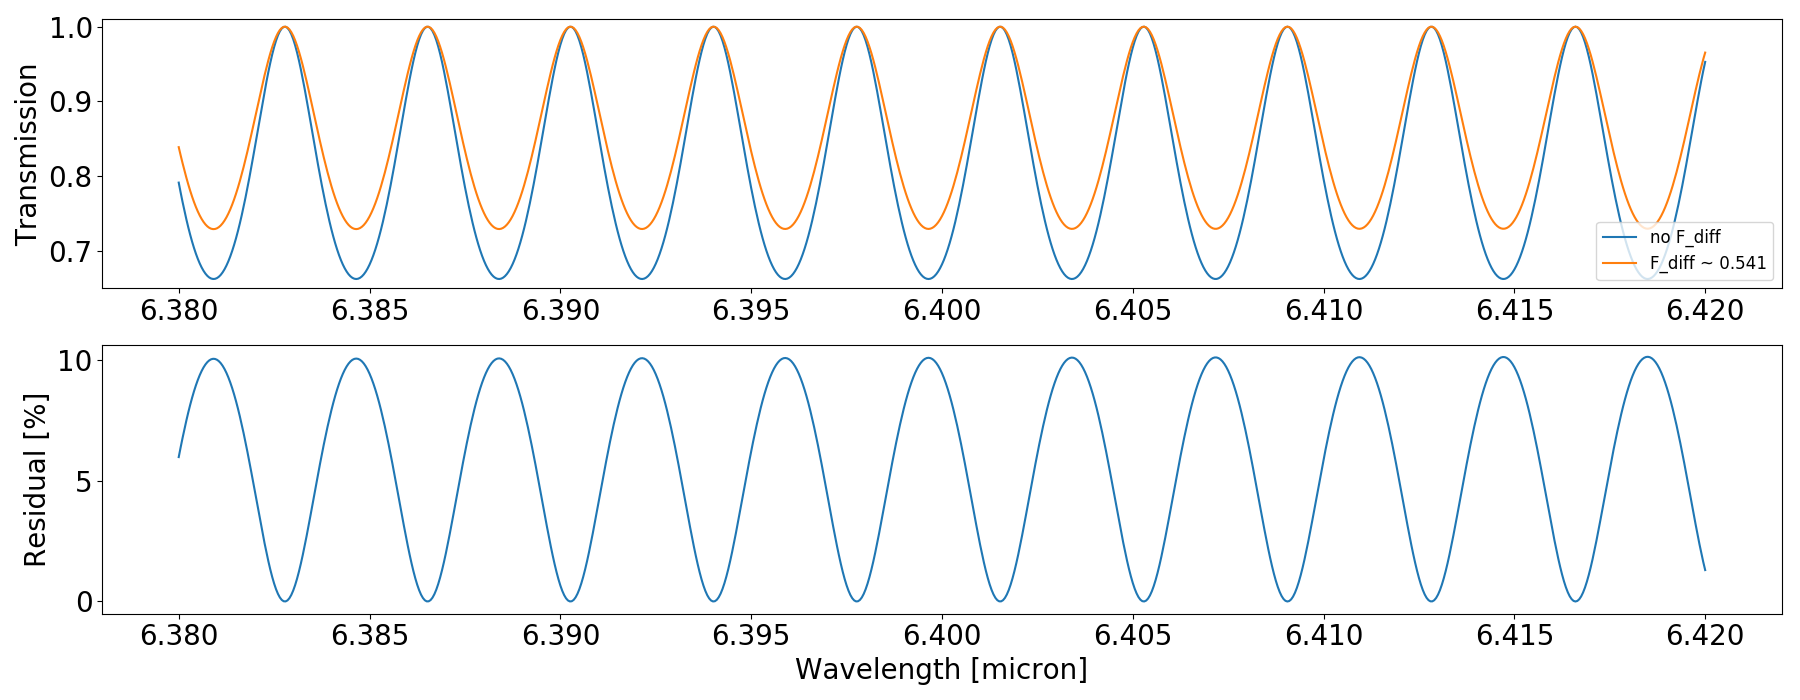

In [41]:
# effect of diffraction finesse
def FPfunc1(wav,D,R,alpha,theta=0):
    lamb0 = 3180. # micron
    D_fp = 0.015 # m, diameter of the beam entering the etalon
    D_tel = 6.5 # m, diameter of primary mirror
    m = lamb0/wav
    n = 3.41
    delta = (2*np.pi/wav)*2.*n*D*np.cos(theta*np.pi/180.)
    F = 4.*R/(1-R**2.)
    F_R = np.pi*np.sqrt(R)/(1-R)
    F_a = 2*np.pi*n / (m*np.pi*alpha**2.)
    F_dif = D_fp**2 / (wav*10**-6 * D_tel)
    F_d = 42.2381 # surface defects
    F_e = np.sqrt( 1. / ((1/F_R**2) + (1/F_a**2) )) # + (1/F_tilt**2) + (1/F_dif**2)) + (1/F_d**2)
    # "contrast": C = 1 + (4*F_e**2/np.pi**2)
    T_e = 1 / ( 1 + F_e * np.sin(delta/2)**2 )
    return T_e

def FPfunc2(wav,D,R,alpha,theta=0):
    lamb0 = 3180. # micron
    D_fp = 0.015 # m, diameter of the beam entering the etalon
    D_tel = 6.5 # m, diameter of primary mirror
    m = lamb0/wav
    n = 3.41
    delta = (2*np.pi/wav)*2.*n*D*np.cos(theta*np.pi/180.)
    F = 4.*R/(1-R**2.)
    F_R = np.pi*np.sqrt(R)/(1-R)
    F_a = 2*np.pi*n / (m*np.pi*alpha**2.)
    F_dif = D_fp**2 / (wav*10**-6 * D_tel)
    F_d = 42.2381 # surface defects
    F_e = np.sqrt( 1. / ((1/F_R**2) + (1/F_a**2) + (1/F_dif**2) )) # + (1/F_tilt**2) + (1/F_dif**2)) + (1/F_d**2)
    T_e = 1 / ( 1 + F_e * np.sin(delta/2)**2 )
    return T_e

def FPfunc3(wav,D,R,alpha,theta=0):
    lamb0 = 3180. # micron
    D_fp = 0.015 # m, diameter of the beam entering the etalon
    D_tel = 6.5 # m, diameter of primary mirror
    m = lamb0/wav
    n = 3.41
    delta = (2*np.pi/wav)*2.*n*D*np.cos(theta*np.pi/180.)
    F = 4.*R/(1-R**2.)
    F_R = np.pi*np.sqrt(R)/(1-R)
    F_a = 2*np.pi*n / (m*np.pi*alpha**2.)
    F_dif = 0.1 * D_fp**2 / (wav*10**-6 * D_tel)
    F_d = 42.2381 # surface defects
    F_e = np.sqrt( 1. / ((1/F_R**2) + (1/F_a**2) + (1/F_dif**2) )) # + (1/F_tilt**2) + (1/F_dif**2)) + (1/F_d**2)
    T_e = 1 / ( 1 + F_e * np.sin(delta/2)**2 )
    return T_e

wavs = np.arange(6.38,6.42,0.00005)
test1,test2,test3 = [np.zeros(len(wavs)) for i in range(3)]
for i in range(len(wavs)):
    test1[i] = FPfunc1(wavs[i],1590.,0.025,0.0125,theta=0)
    test2[i] = FPfunc2(wavs[i],1590.,0.025,0.0125,theta=0)
    test3[i] = FPfunc3(wavs[i],1590.,0.025,0.0125,theta=0)


fig,axs = plt.subplots(2,1,figsize=(18,7))
axs[0].plot(wavs,test1,label=r'no F_diff')
axs[0].plot(wavs,test2,label=r'F_diff ~ {}'.format(round(0.015**2 / ( ((wavs[0]+wavs[-1])/2.) *10**-6 * 6.5),3) ))
axs[0].plot(wavs,test3,label=r'F_diff ~ {}'.format(round(0.1 * 0.015**2 / ( ((wavs[0]+wavs[-1])/2.) *10**-6 * 6.5),3) ))
axs[0].set_ylim(0.65,1.01)
axs[0].set_ylabel('Transmission')
axs[0].legend(loc='lower right',fontsize=12)
axs[1].plot(wavs,abs((test2-test1)/test1)*100.,label='Difference test 1 / test 2')
axs[1].plot(wavs,abs((test3-test1)/test1)*100.,label='Difference test 1 / test 3')
axs[1].set_ylabel('Residual [%]')
axs[1].set_xlabel('Wavelength [micron]')
axs[1].legend(loc='lower right',fontsize=12)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


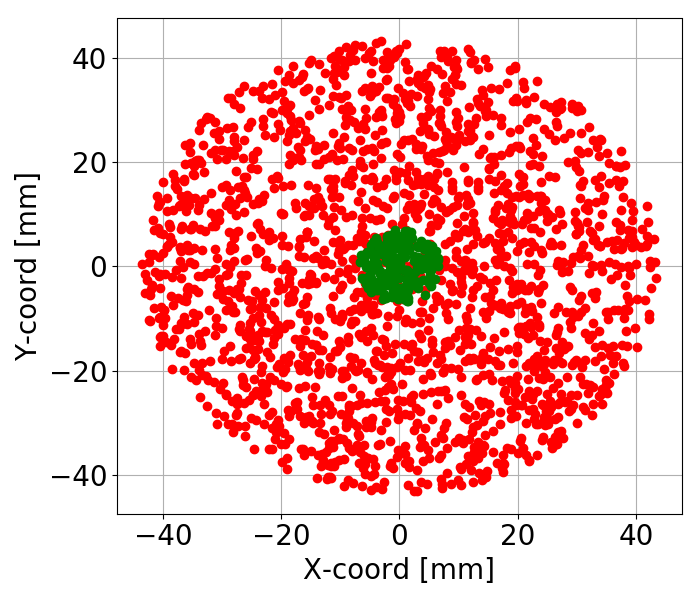

In [4]:
n = 2000

length1 = 43.5*np.sqrt(np.random.uniform(0, 1, n))
angle = np.pi * np.random.uniform(0, 2, n)

# circle with coordinates
x1 = length1 * np.cos(angle)
y1 = length1 * np.sin(angle)

n = 200

length2 = 7.*np.sqrt(np.random.uniform(0, 1, n))
angle = np.pi * np.random.uniform(0, 2, n)

x2 = length2 * np.cos(angle)
y2 = length2 * np.sin(angle)

plt.figure(figsize=(7,6))
plt.plot(x1,y1,'ro')
plt.plot(x2,y2,'go',label='')
plt.xlabel('X-coord [mm]')
plt.ylabel('Y-coord [mm]')
plt.grid()
plt.tight_layout()

In [72]:
# Simple averaging over 2 dimensions - calibration beam
n = 1000

length = 7.*np.sqrt(np.random.uniform(0, 1, n))
angle = np.pi * np.random.uniform(0, 2, n)

thetas = np.arctan(length/297.)*180./np.pi

# # circle with coordinates
# x = length * np.cos(angle)
# y = length * np.sin(angle)

Refl_cal,Transm_cal,Absorp_cal = {},{},{}
for band in ['1A']:
    Refl_cal[band],Transm_cal[band],Absorp_cal[band] = [np.zeros(len(wav[band])) for i in range(3)]
    for i,wvl in enumerate(wav[band]):
        # define stack of refractive layers
        n_list = [1,n_ZnS[band][i],n_Si[band][i],n_BE[band][i],n_SiAs[band][i], n_Al[band][i]] # refractive index
        lambda_vac = wvl*1000. # convert microns to nanometers
        Refl_cal[band][i],Transm_cal[band][i],Absorp_cal[band][i] = 0,0,0
        for theta in thetas:
            # solve the Fresnel equations using the Transfer-Matrix Method
            Reflectance,Transmittance,Absorptance = funcs.simple_tmm(n_list, d_list, theta*deg, lambda_vac)
            Refl_cal[band][i] += Reflectance
            Transm_cal[band][i] += Transmittance
            Absorp_cal[band][i] += Absorptance
        Refl_cal[band][i] /= len(thetas)
        Transm_cal[band][i] /= len(thetas)
        Absorp_cal[band][i] /= len(thetas)

In [ ]:
# Integratin via trapezoidal rule (i.e. 2-point Newton-Cotes formula)
# theta_max = np.arctan(97./297.) # radians
# D_max = 297. * np.tan(theta_max) # mm
# Delta_R = D_max/2./1000. # mm

thetas = np.arange(0,9.01,0.01)

d_list = [np.inf, 0.72e3,460.5e3,0.3e3,35e3, np.inf] # thickness, nanometers

Refl,Transm,Absorp = {},{},{}
for band in ['1A']:
    Refl[band],Transm[band],Absorp[band] = [np.zeros(len(wav[band])) for i in range(3)]
    for i,wvl in enumerate(wav[band][:2]):
        print Absorp_0[band][i]
        # define stack of refractive layers
        n_list = [1,n_ZnS[band][i],n_Si[band][i],n_BE[band][i],n_SiAs[band][i], n_Al[band][i]] # refractive index
        lambda_vac = wvl*1000. # convert microns to nanometers
        Refl[band][i],Transm[band][i],Absorp[band][i] = 0,0,0
        for i in range(len(thetas)-1):
            Reflectance1,Transmittance1,Absorptance1 = funcs.simple_tmm(n_list, d_list, thetas[i]*deg, lambda_vac)
            Reflectance2,Transmittance2,Absorptance2 = funcs.simple_tmm(n_list, d_list, thetas[i+1]*deg, lambda_vac)
            print Absorptance1,Absorptance2
#             Delta_R = 297. * np.tan( (thetas[i+1]-thetas[i])*np.pi/180.)
#             R1,R2 = 297. * np.tan( thetas[i]*np.pi/180.), 297. * np.tan( thetas[i+1]*np.pi/180.)
#             Refl[band][i] += 0.5 * Delta_R * (Reflectance1*2.*np.pi* R1 + Reflectance2*2.*np.pi* R2)
#             Transm[band][i] += 0.5 * Delta_R * (Transmittance1*2.*np.pi* R1 + Transmittance2*2.*np.pi* R2)
#             Absorp[band][i] += 0.5 * Delta_R * (Absorptance1*2.*np.pi* R1 + Absorptance2*2.*np.pi* R2)
#         Refl[band][i] /= np.pi* 297. * np.tan( thetas[-1]*np.pi/180.)
#         Transm[band][i] /= np.pi* 297. * np.tan( thetas[-1]*np.pi/180.)
#         Absorp[band][i] /= np.pi* 297. * np.tan( thetas[-1]*np.pi/180.)

<IPython.core.display.Javascript object>


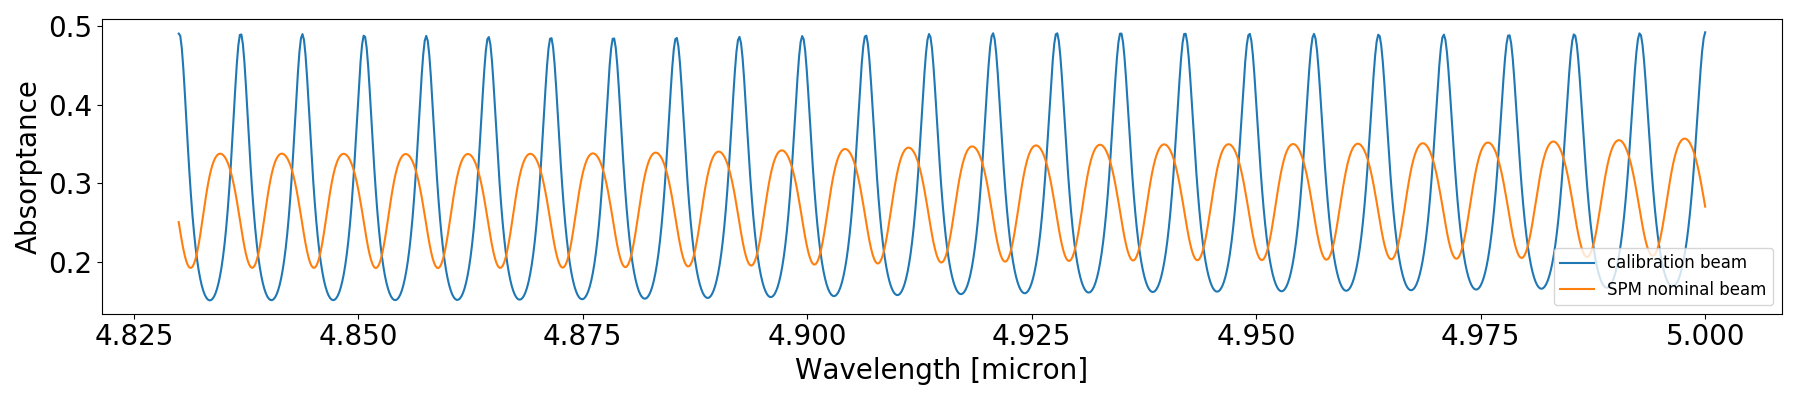

In [78]:
plt.figure(figsize=(18,4))
# plt.plot(wav[band],Absorp_0[band],label='normal inclination spectrum')
plt.plot(wav[band],Absorp_cal[band],label='calibration beam')
plt.plot(wav[band],Absorp[band],label='SPM nominal beam')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Absorptance')
plt.legend(loc='lower right',fontsize=12)
plt.tight_layout()

In [18]:
lambda_centers,lambda_fwhms,spec_res,linear_spec_res = {},{},{},{}
for band in ['1A']:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr80pc'.format(band),path=d2cMapDir)
    specres_table = funcs.get_cdps(band,cdpDir)[4]
    
    # construct spectral grid
    lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)
    lambcens,lambfwhms = lambcens[1:],lambfwhms[1:]
    
    # save output
    lambda_centers[band] = lambcens
    lambda_fwhms[band] = lambfwhms
    # derive spectral resolution
    Res = np.zeros(len(lambcens))
    for ibin in range(len(lambcens)):
        Res[ibin] = funcs.getSpecR(lamb0=lambcens[ibin],band=band,specres_table=specres_table)
    
    # save output
    lambda_centers[band] = lambcens
    lambda_fwhms[band] = lambfwhms
    spec_res[band] = Res

lamb_fwhms = {}
for band in ['1A']:
    arr_interpolator = InterpolatedUnivariateSpline(lambda_centers[band],lambda_centers[band]/spec_res[band],k=3,ext=0)
    lamb_fwhms[band] = arr_interpolator(wav[band])

In [27]:
degr_Refl,degr_Transm,degr_Absorp = {},{},{}
degr_Refl_cal,degr_Transm_cal,degr_Absorp_cal = {},{},{}
for band in ['1A']:
    degr_Absorp[band] = np.zeros(len(wav[band]))
    degr_Absorp_cal[band] = np.zeros(len(wav[band]))
    for i in range(len(wav[band])):
        degraded_spectrum = funcs.convolvegauss_windt(wav[band],Absorp[band],lamb_fwhms[band][i])
        degr_Absorp[band][i] = degraded_spectrum[i]
        degraded_spectrum_cal = funcs.convolvegauss_windt(wav[band],Absorp_cal[band],lamb_fwhms[band][i])
        degr_Absorp_cal[band][i] = degraded_spectrum_cal[i]

<IPython.core.display.Javascript object>


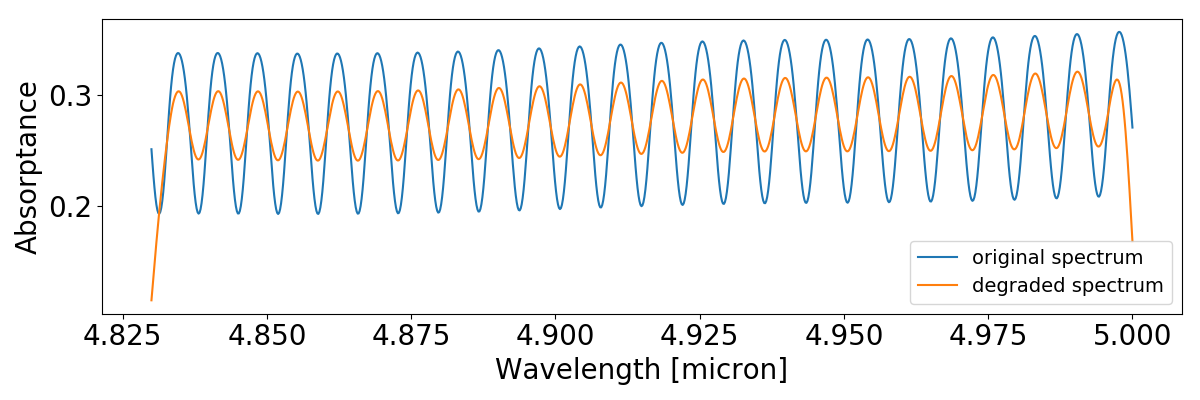

In [30]:
plt.figure(figsize=(12,4))
plt.plot(wav[band],Absorp[band],label='original spectrum')
plt.plot(wav[band],degr_Absorp[band],label='degraded spectrum')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Absorptance')
plt.legend(loc='lower right')
plt.tight_layout()

In [21]:
degr_Refl_0,degr_Transm_0,degr_Absorp_0 = {},{},{}
for band in ['1A']:
    degr_Absorp_0[band] = np.zeros(len(wav[band]))
    for i in range(len(wav[band])):
        degraded_spectrum = funcs.convolvegauss_windt(wav[band],Absorp_0[band],lamb_fwhms[band][i])
        degr_Absorp_0[band][i] = degraded_spectrum[i]

# plt.figure(figsize=(12,4))
# plt.plot(wav[band],Transm_0[band])
# plt.plot(wav[band],Transm[band])
# plt.xlabel('Wavelength [um]')
# plt.ylabel('Transmittance')
# plt.tight_layout()

# plt.figure(figsize=(12,4))
# plt.plot(wav[band],Refl_0[band])
# plt.plot(wav[band],Refl[band])
# plt.xlabel('Wavelength [um]')
# plt.ylabel('Reflectance')
# plt.tight_layout()

# plt.figure(figsize=(18,4))
# plt.plot(wav[band],Absorp_0[band],alpha=0.2,label='normal-incidence spectrum')
# plt.plot(wav[band],Absorp[band],alpha=0.2,label='cone-averaged spectrum')
# plt.plot(wav[band],degr_Absorp_0[band],label='degraded normal-incidence spectrum')
# plt.plot(wav[band],degr_Absorp[band],label='degraded cone-averaged spectrum')
# plt.xlabel('Wavelength [um]')
# plt.ylabel('Absorptance')
# plt.legend(loc='best',fontsize=12)
# plt.tight_layout()

<IPython.core.display.Javascript object>


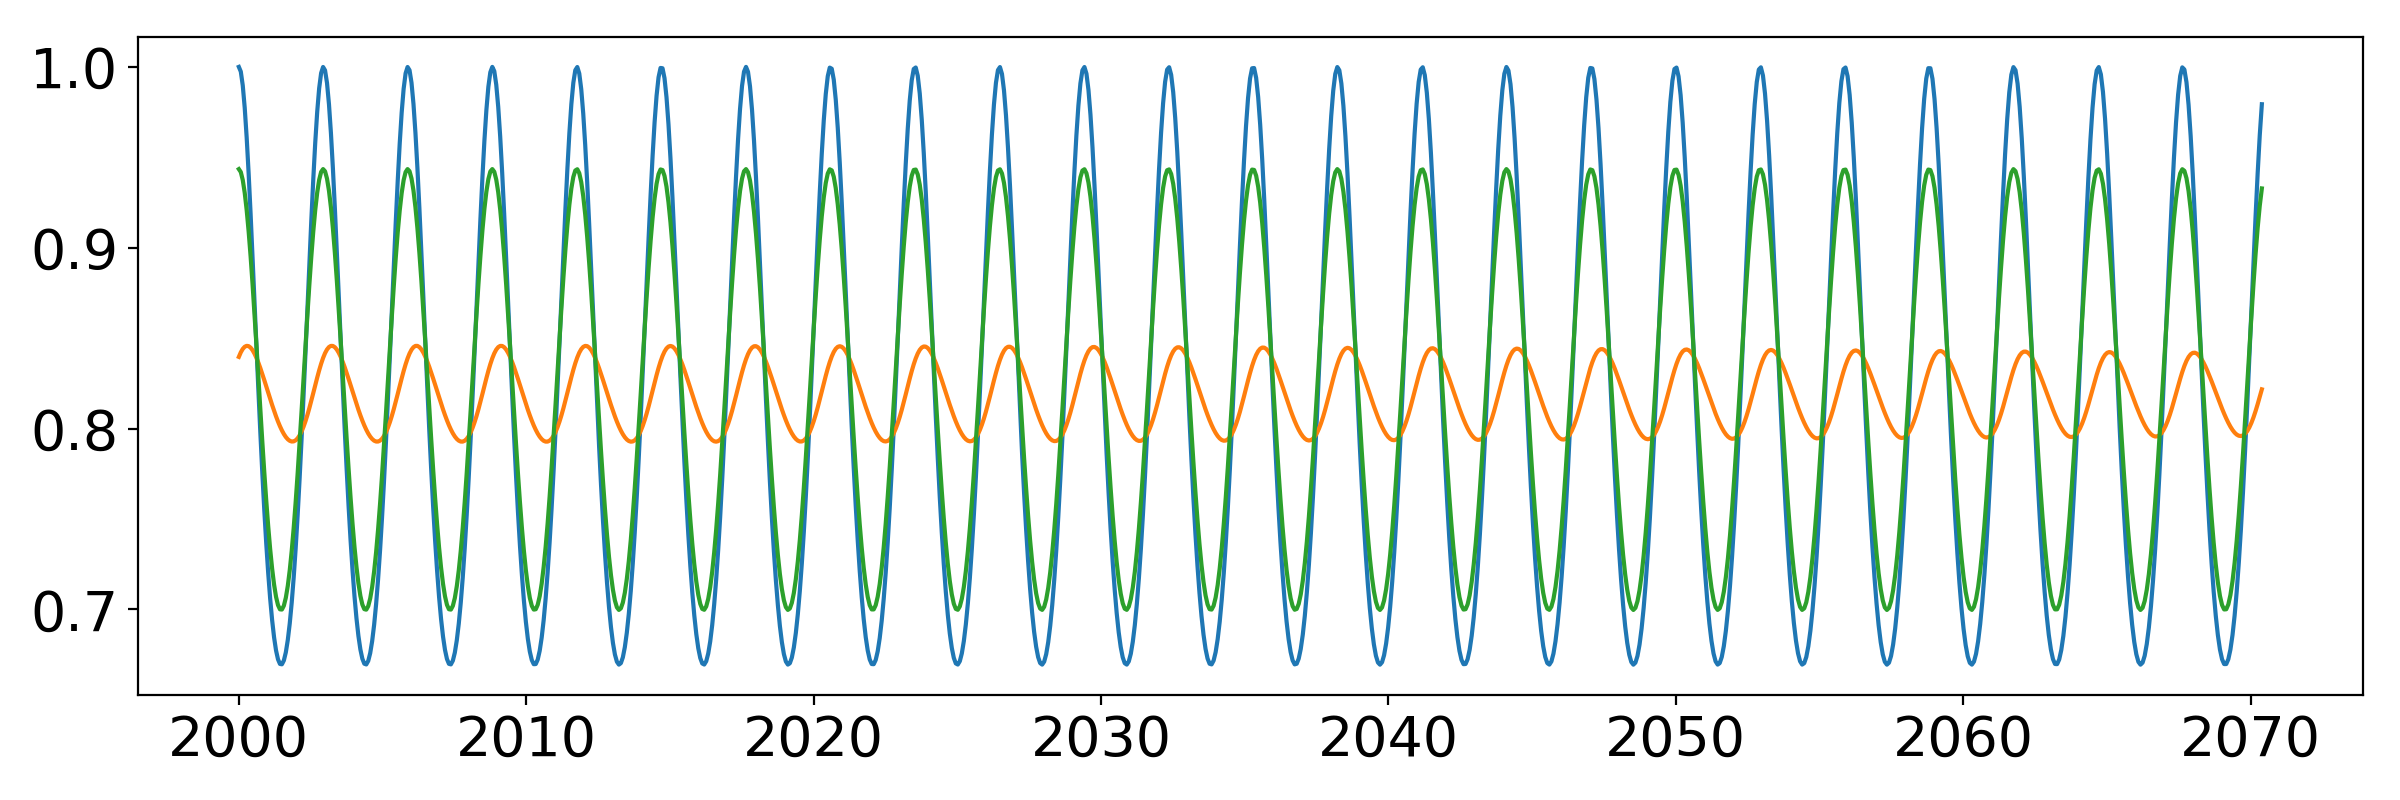

In [52]:
wvnr = np.flipud(10000./wav['1A'])

thetas = np.random.uniform(0,9.01,1001)
phases = np.random.uniform(-0.2*np.pi,0.2*np.pi,1001)
test_inc = 0
for theta in thetas:
    test_inc += funcs.FPfunc_noPhaseShift(wvnr,0.1,0.17,theta=theta*deg)
test_inc/=len(thetas)

test_phase = 0
for phase in phases:
    test_phase += funcs.FPfunc(wvnr,0.1,0.17,phase)
test_phase/=len(phases)

# test1 = funcs.FPfunc_noPhaseShift(wvnr,0.1,0.17,theta=0)
# test2 = funcs.FPfunc_noPhaseShift(wvnr,0.1,0.17,theta=10.*deg)
# test3 = funcs.FPfunc_noPhaseShift(wvnr,0.1,0.17,theta=-10.*deg)

plt.figure(figsize=(12,4))
plt.plot(wvnr,funcs.FPfunc_noPhaseShift(wvnr,0.1,0.17,theta=0.))
plt.plot(wvnr,test_inc)
plt.plot(wvnr,test_phase)
# plt.plot(wvnr,test1)
# plt.plot(wvnr,test2)
# plt.plot(wvnr,(test1+test2)/2.)
plt.tight_layout()

<IPython.core.display.Javascript object>


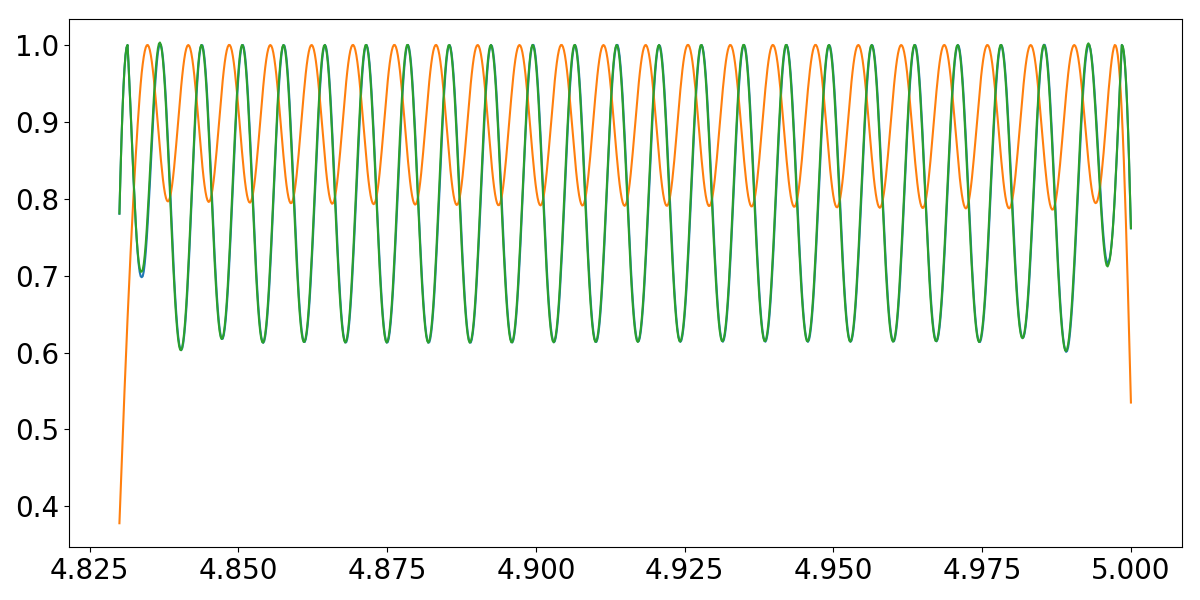

In [29]:
Absorp_0_norm = funcs.norm_fringe(degr_Absorp_0[band],min_dist=2)
Absorp_norm = funcs.norm_fringe(degr_Absorp[band],min_dist=2)
Absorp_cal_norm = funcs.norm_fringe(degr_Absorp_cal[band],min_dist=2)

plt.figure(figsize=(12,6))
plt.plot(wav[band],Absorp_0_norm[0]/Absorp_0_norm[2])
plt.plot(wav[band],Absorp_norm[0]/Absorp_norm[2])
plt.plot(wav[band],Absorp_cal_norm[0]/Absorp_cal_norm[2])
plt.tight_layout()

<IPython.core.display.Javascript object>


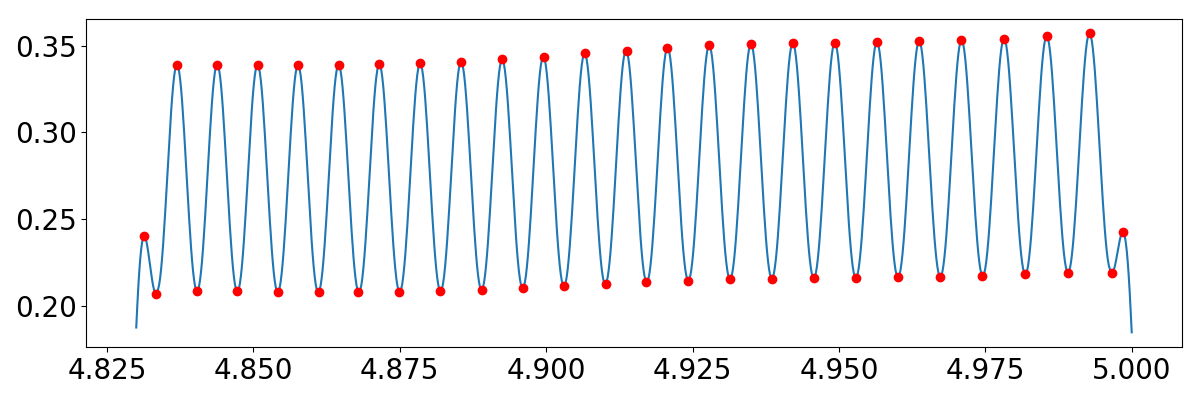

4.83697697698 4.9965965966
4.84378378378 4.8334034034
4.85076076076 4.84038038038
4.85756756757 4.84718718719
4.86454454454 4.85416416416
4.87152152152 4.86114114114
4.8784984985 4.86794794795
4.88547547548 4.87492492492
4.89245245245 4.8819019019
4.8995995996 4.88904904905
4.90657657658 4.89602602603
4.91372372372 4.903003003
4.9207007007 4.91015015015
4.92784784785 4.91712712713
4.93499499499 4.92427427427
4.94214214214 4.93142142142
4.94928928929 4.93856856857
4.95643643644 4.94571571572
4.96375375375 4.95286286286
4.9709009009 4.96001001001
4.97821821822 4.96732732733
4.98553553554 4.97447447447
4.99285285285 4.98179179179


<IPython.core.display.Javascript object>


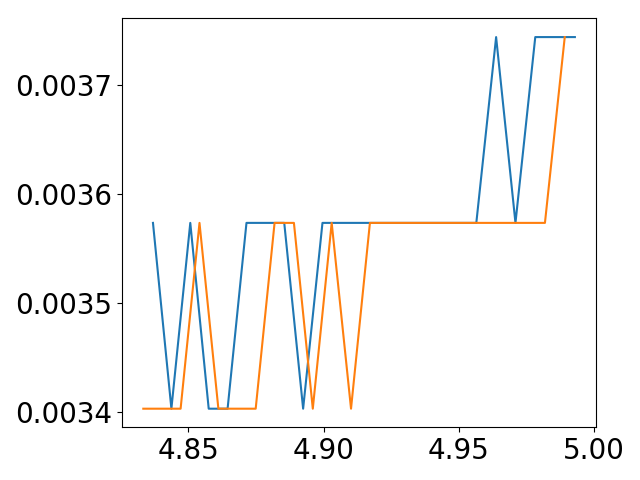

In [23]:
Absorp_0_norm_pos = funcs.norm_fringe(degr_Absorp_0[band],min_dist=2)
Absorp_0_norm_neg = funcs.norm_fringe(-degr_Absorp_0[band],min_dist=2)
# Absorp_norm = funcs.norm_fringe(-degr_Absorp[band],min_dist=2)

plt.figure(figsize=(12,4))
plt.plot(wav[band],-Absorp_0_norm_neg[0])
plt.plot(wav[band][Absorp_0_norm_pos[1]],Absorp_0_norm_pos[0][Absorp_0_norm_pos[1]],'ro')
plt.plot(wav[band][Absorp_0_norm_neg[1]],-Absorp_0_norm_neg[0][Absorp_0_norm_neg[1]],'ro')
# plt.plot(wav[band]-0.0008,Absorp_0_norm[0]/Absorp_0_norm[2])
# plt.plot(wav[band],Absorp_norm[0]/Absorp_norm[2])
plt.tight_layout()

wav1,wav2,test1,test2 = [],[],[],[]
for i in range(len(Absorp_0_norm_neg[1])-1):
    test1.append(wav[band][Absorp_0_norm_pos[1]][1:][i]-wav[band][Absorp_0_norm_neg[1]][i])
    print wav[band][Absorp_0_norm_pos[1]][1:][i],wav[band][Absorp_0_norm_neg[1]][i-1]
    test2.append(wav[band][Absorp_0_norm_neg[1]][i+1]-wav[band][Absorp_0_norm_pos[1]][1:][i])
    wav1.append(wav[band][Absorp_0_norm_pos[1]][1:][i])
    wav2.append(wav[band][Absorp_0_norm_neg[1]][i])

plt.figure()
# plt.plot(wav[band][Absorp_0_norm_pos[1]]-wav[band][Absorp_0_norm_neg[1]][:-1])
# plt.plot(wav[band][Absorp_0_norm_pos[1]]-wav[band][Absorp_0_norm_neg[1]][:-1])
plt.plot(wav1,test1)
plt.plot(wav2,test2)
plt.tight_layout()

In [20]:
print 4.8438-4.84038
print 4.84728-4.8438

0.00342
0.00348


<IPython.core.display.Javascript object>


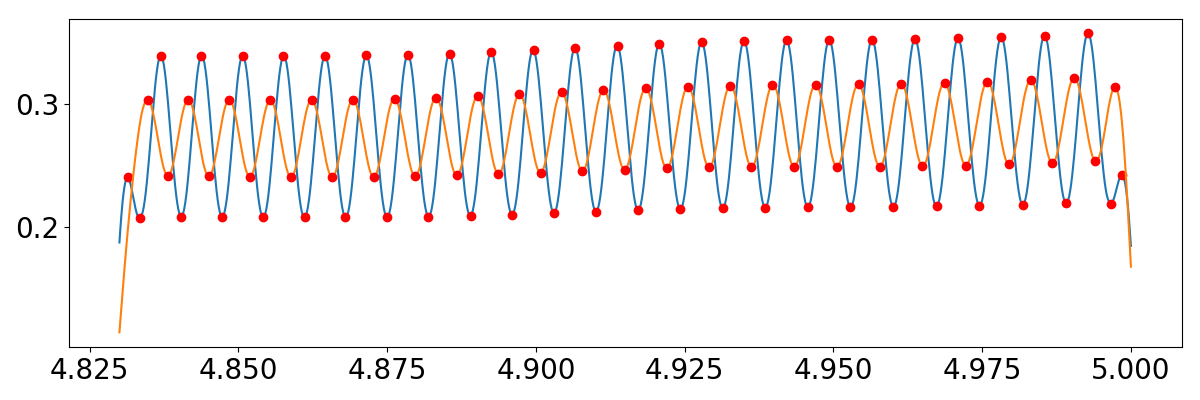

<IPython.core.display.Javascript object>


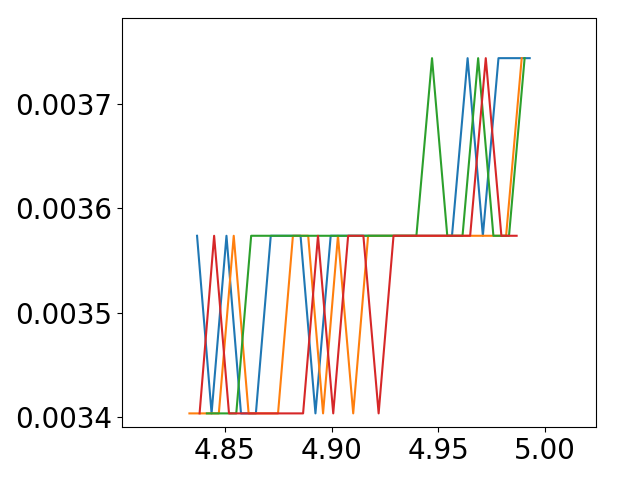

In [24]:
Absorp_norm_pos = funcs.norm_fringe(degr_Absorp[band],min_dist=2)
Absorp_norm_neg = funcs.norm_fringe(-degr_Absorp[band],min_dist=2)
Absorp_norm = funcs.norm_fringe(-degr_Absorp[band],min_dist=2)

plt.figure(figsize=(12,4))
plt.plot(wav[band],-Absorp_0_norm_neg[0])
plt.plot(wav[band][Absorp_0_norm_pos[1]],Absorp_0_norm_pos[0][Absorp_0_norm_pos[1]],'ro')
plt.plot(wav[band][Absorp_0_norm_neg[1]],-Absorp_0_norm_neg[0][Absorp_0_norm_neg[1]],'ro')
plt.plot(wav[band],-Absorp_norm_neg[0])
plt.plot(wav[band][Absorp_norm_pos[1]],Absorp_norm_pos[0][Absorp_norm_pos[1]],'ro')
plt.plot(wav[band][Absorp_norm_neg[1]],-Absorp_norm_neg[0][Absorp_norm_neg[1]],'ro')
plt.tight_layout()

wav3,wav4,test3,test4 = [],[],[],[]
for i in range(len(Absorp_norm_neg[1])-1):
    test3.append(wav[band][Absorp_norm_pos[1]][1:][i]-wav[band][Absorp_norm_neg[1]][i])
    test4.append(wav[band][Absorp_norm_neg[1]][i+1]-wav[band][Absorp_norm_pos[1]][1:][i])
    wav3.append(wav[band][Absorp_norm_pos[1]][1:][i])
    wav4.append(wav[band][Absorp_norm_neg[1]][i])

plt.figure()
plt.plot(wav1,test1)
plt.plot(wav2,test2)
plt.plot(wav3,test3)
plt.plot(wav4,test4)
plt.tight_layout()